# Klasifikacija slika: k-NN na skupu rukom pisanih cifara (8×8)

## Seminarski rad - SISJ

Autor: Mihajlović Luka 2020/0136, Ilić Andrija 2020/0236  
Datum: 23.07.2025.

---

U ovom notebook-u demonstriramo jednostavan model za klasifikaciju slika korišćenjem skupa rukom pisanih cifara (sklearn digits, 8×8 piksela). Za klasifikator koristimo k-Nearest Neighbors (k-NN), a Seaborn nam služi za jasne i lepe vizualizacije rezultata.

Šta radimo:
- Šta je klasifikacija slika (kratko objašnjenje)
- Učitavanje i pregled slikovnog skupa (primerni uzorci, distribucija klasa)
- Treniranje baznog k-NN modela (sa skaliranjem piksela)
- Vizualizacija performansi (confusion matrica, tačnost po klasama)
- Tuning hiperparametra k (GridSearchCV, 5-fold CV)
- Analiza grešaka i prikaz pogrešno klasifikovanih slika
- Primer predikcije sa verovatnoćama za nekoliko slika

Napomena: Seaborn je biblioteka za vizualizaciju – samu klasifikaciju radi scikit-learn. Fokus nam je da jednostavno, pregledno i jasno ilustrujemo ceo proces.

In [9]:
# Uvoz biblioteka
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings

# Podešavanje
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

print("✅ Biblioteke učitane!")
print(f"Seaborn verzija: {sns.__version__}")

# Učitavanje skupa rukom pisanih cifara (8×8 pikseli)
digits = load_digits()
X = digits.data           # 64-dim vektor piksela (8×8 raster razvijen u niz)
y = digits.target         # Klase: cifre 0-9
images = digits.images    # 8×8 slike

n_samples, n_features = X.shape
h, w = images.shape[1:]
classes = np.unique(y)

print(f"\n📊 DIGITS DATASET:")
print(f"Broj uzoraka: {n_samples}")
print(f"Dimenzije slike: {h}×{w} (ukupno {n_features} piksela)")
print(f"Klase: {classes.tolist()}")
print(f"Primeri minimalne/maksimalne vrednosti piksela: min={X.min()}, max={X.max()}")

✅ Biblioteke učitane!
Seaborn verzija: 0.13.2

📊 DIGITS DATASET:
Broj uzoraka: 1797
Dimenzije slike: 8×8 (ukupno 64 piksela)
Klase: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Primeri minimalne/maksimalne vrednosti piksela: min=0.0, max=16.0


### 2. Eksploracija slikovnog skupa

Pre klasifikacije, pogledajmo kako izgledaju naše slike i distribuciju klasa.

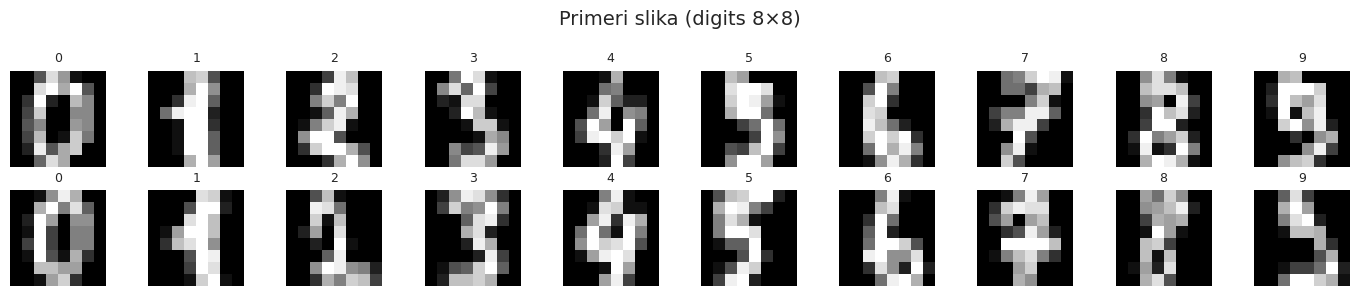

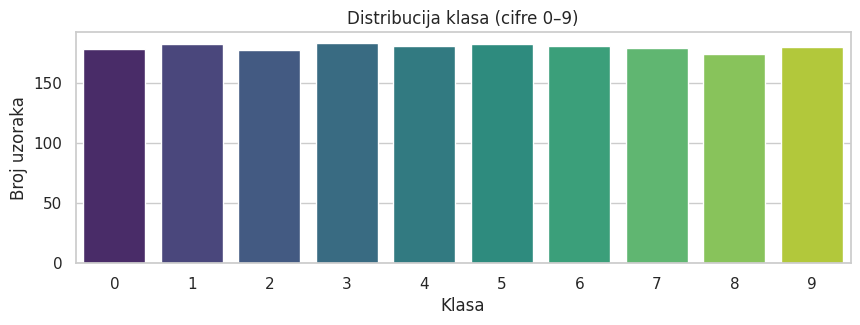

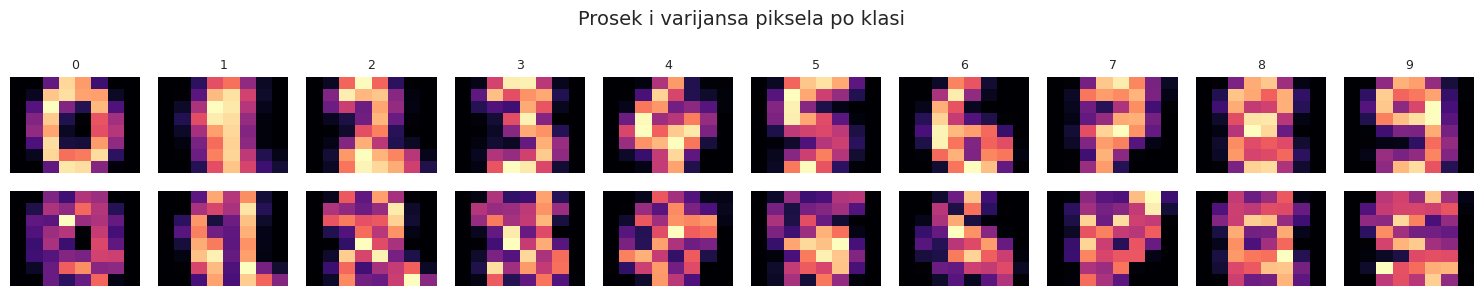

In [10]:
# Eksploracija slikovnog skupa

# 1) Prikaz nekoliko primera slika po klasama
fig, axes = plt.subplots(2, 10, figsize=(14, 3))
fig.suptitle('Primeri slika (digits 8×8)', fontsize=14)
for digit in range(10):
    idxs = np.where(y == digit)[0]
    # nasumično izaberemo do 2 uzorka po klasi
    for r in range(2):
        ax = axes[r, digit]
        if r < len(idxs):
            img = images[idxs[r]]
            ax.imshow(img, cmap='gray')
            ax.set_title(str(digit), fontsize=9)
        ax.axis('off')
plt.tight_layout()
plt.show()

# 2) Distribucija klasa
plt.figure(figsize=(10, 3))
sns.countplot(x=y, palette='viridis')
plt.title('Distribucija klasa (cifre 0–9)')
plt.xlabel('Klasa')
plt.ylabel('Broj uzoraka')
plt.show()

# 3) Prosečna slika po klasi i varijansa – heatmap
mean_images = np.array([images[y == c].mean(axis=0) for c in classes])
var_images = np.array([images[y == c].var(axis=0) for c in classes])

fig, ax = plt.subplots(2, 10, figsize=(15, 3))
fig.suptitle('Prosek i varijansa piksela po klasi', fontsize=14)
for i, c in enumerate(classes):
    sns.heatmap(mean_images[i], ax=ax[0, i], cmap='magma', cbar=False)
    ax[0, i].set_title(f'{c}', fontsize=9)
    ax[0, i].axis('off')
    sns.heatmap(var_images[i], ax=ax[1, i], cmap='magma', cbar=False)
    ax[1, i].axis('off')
ax[0, 0].set_ylabel('Prosek', rotation=0, labelpad=30)
ax[1, 0].set_ylabel('Var', rotation=0, labelpad=30)
plt.tight_layout()
plt.show()

### 3. k-Nearest Neighbors (k-NN) za klasifikaciju slika

k-NN klasifikuje novu sliku na osnovu najbližih suseda u prostoru piksela. Za k-NN je važno skaliranje karakteristika (piksela), zato koristimo StandardScaler u sklopu scikit-learn Pipeline-a.

In [11]:
# Podela na train i test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("📊 PODELA PODATAKA:")
print(f"Training set: {X_train.shape[0]} uzoraka")
print(f"Test set: {X_test.shape[0]} uzoraka")

# Pipeline: skaliranje + kNN
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=3))
])

# Treniranje
pipe.fit(X_train, y_train)

# Predikcija na test setu
y_pred = pipe.predict(X_test)

# Evaluacija
accuracy = accuracy_score(y_test, y_pred)
print("\n📈 REZULTATI (bazni model):")
print(f"Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print("\n📋 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))

📊 PODELA PODATAKA:
Training set: 1347 uzoraka
Test set: 450 uzoraka

📈 REZULTATI (bazni model):
Accuracy: 0.967 (96.7%)

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.94      0.98      0.96        46
           2       0.94      1.00      0.97        44
           3       0.98      0.98      0.98        46
           4       0.98      0.93      0.95        45
           5       1.00      0.96      0.98        46
           6       0.98      1.00      0.99        45
           7       0.94      1.00      0.97        45
           8       0.97      0.88      0.93        43
           9       0.95      0.93      0.94        45

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450



### 4. Vizualizacija rezultata (Seaborn)

Prikazujemo confusion matricu i tačnost po klasama za digits.

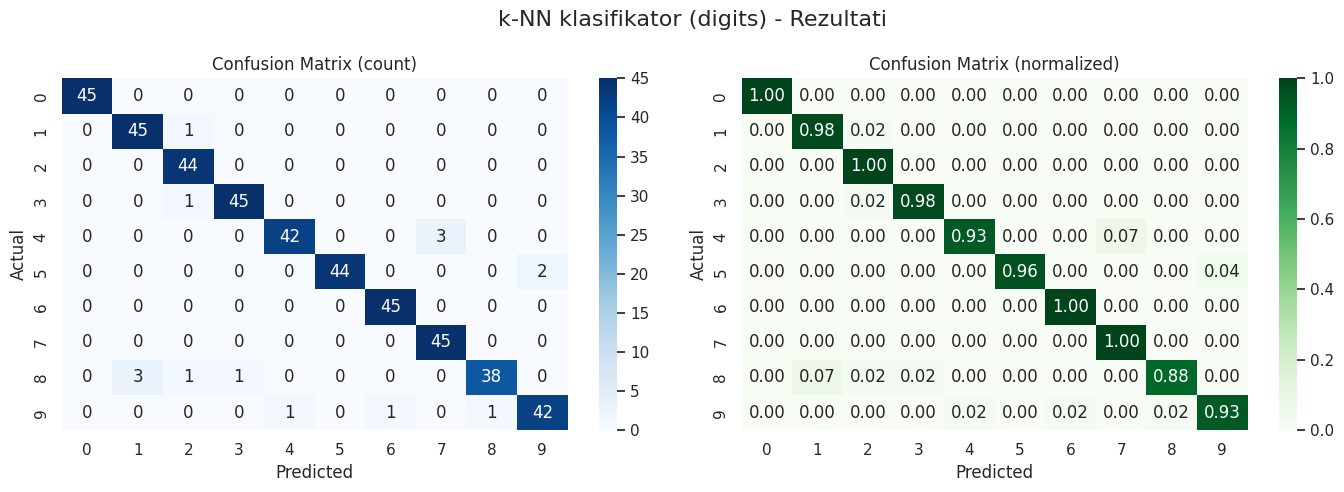

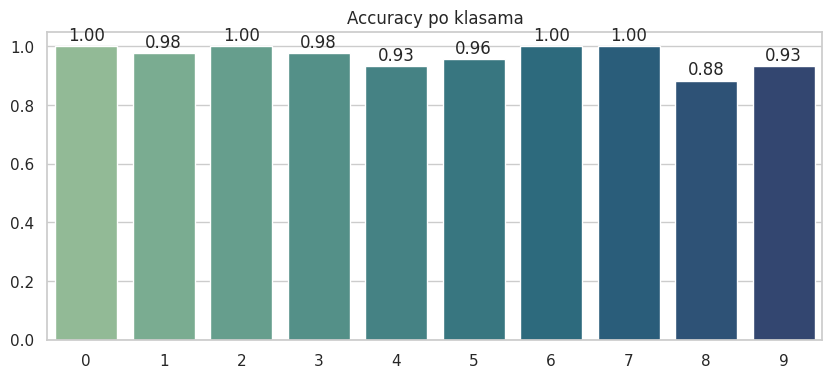

❌ Broj pogrešnih klasifikacija: 15 / 450


In [12]:
# Confusion Matrix (apsolutne vrednosti i normalizovana)
cm = confusion_matrix(y_test, y_pred)
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('k-NN klasifikator (digits) - Rezultati', fontsize=16)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes, ax=axes[0])
axes[0].set_title('Confusion Matrix (count)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=classes, yticklabels=classes, ax=axes[1])
axes[1].set_title('Confusion Matrix (normalized)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Tačnost po klasama
class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 4))
sns.barplot(x=classes, y=class_acc, palette='crest')
plt.title('Accuracy po klasama')
plt.ylim(0, 1.05)
for i, acc in enumerate(class_acc):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center')
plt.show()

errors = np.where(y_test != y_pred)[0]
print(f"❌ Broj pogrešnih klasifikacija: {len(errors)} / {len(y_test)}")

### 5. Tuning hiperparametra k (GridSearchCV)

Proveravamo različite vrednosti k koristeći 5-fold stratifikovanu unakrsnu validaciju.

🔍 Rezultati GridSearchCV (5-fold CV):
k= 1 -> acc=0.968 ± 0.008
k= 2 -> acc=0.962 ± 0.006
k= 3 -> acc=0.973 ± 0.004
k= 4 -> acc=0.973 ± 0.008
k= 5 -> acc=0.975 ± 0.005
k= 6 -> acc=0.968 ± 0.007
k= 7 -> acc=0.967 ± 0.007
k= 8 -> acc=0.964 ± 0.008
k= 9 -> acc=0.964 ± 0.007
k=10 -> acc=0.963 ± 0.006
k=11 -> acc=0.960 ± 0.006
k=12 -> acc=0.958 ± 0.003
k=13 -> acc=0.959 ± 0.005
k=14 -> acc=0.958 ± 0.004
k=15 -> acc=0.955 ± 0.007

🏆 Najbolje k: 5 (CV accuracy=0.975)


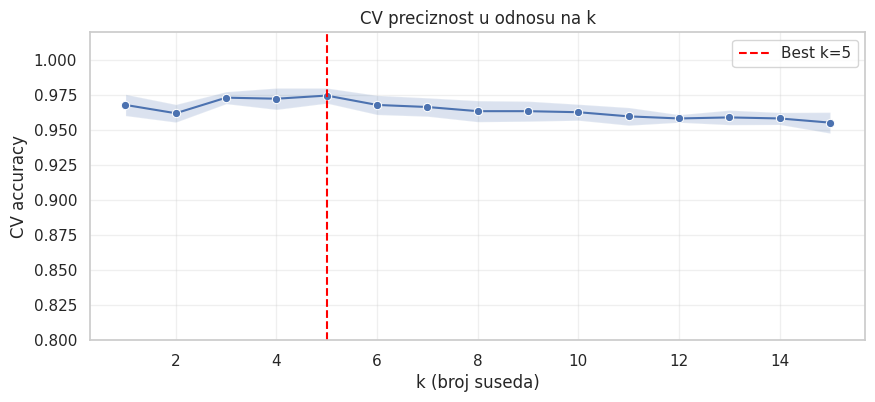

✅ Test accuracy sa najboljim k=5: 0.964 (96.4%)


In [13]:
# GridSearchCV za k
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pipe_cv = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
param_grid = {'knn__n_neighbors': list(range(1, 16))}

grid = GridSearchCV(pipe_cv, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, return_train_score=True)
grid.fit(X_train, y_train)

means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
ks = grid.cv_results_['param_knn__n_neighbors'].data.astype(int)

best_k = int(grid.best_params_['knn__n_neighbors'])
best_cv = float(grid.best_score_)

print("🔍 Rezultati GridSearchCV (5-fold CV):")
for k_val, m, s in zip(ks, means, stds):
    print(f"k={k_val:2d} -> acc={m:.3f} ± {s:.3f}")

print(f"\n🏆 Najbolje k: {best_k} (CV accuracy={best_cv:.3f})")

# Kriva preciznosti
plt.figure(figsize=(10, 4))
sns.lineplot(x=ks, y=means, marker='o')
plt.fill_between(ks, means - stds, means + stds, alpha=0.2)
plt.axvline(best_k, color='red', linestyle='--', label=f'Best k={best_k}')
plt.title('CV preciznost u odnosu na k')
plt.xlabel('k (broj suseda)')
plt.ylabel('CV accuracy')
plt.legend()
plt.ylim(0.8, 1.02)
plt.grid(True, alpha=0.3)
plt.show()

# Treniramo finalni model sa najboljim k i procenjujemo na test skupu
final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])
final_model.fit(X_train, y_train)
final_pred = final_model.predict(X_test)
final_acc = accuracy_score(y_test, final_pred)
print(f"✅ Test accuracy sa najboljim k={best_k}: {final_acc:.3f} ({final_acc*100:.1f}%)")

### 6. Primer klasifikacije i analiza grešaka

Klasifikujemo nekoliko slika iz testa i prikazujemo verovatnoće, kao i primere pogrešnih klasifikacija.

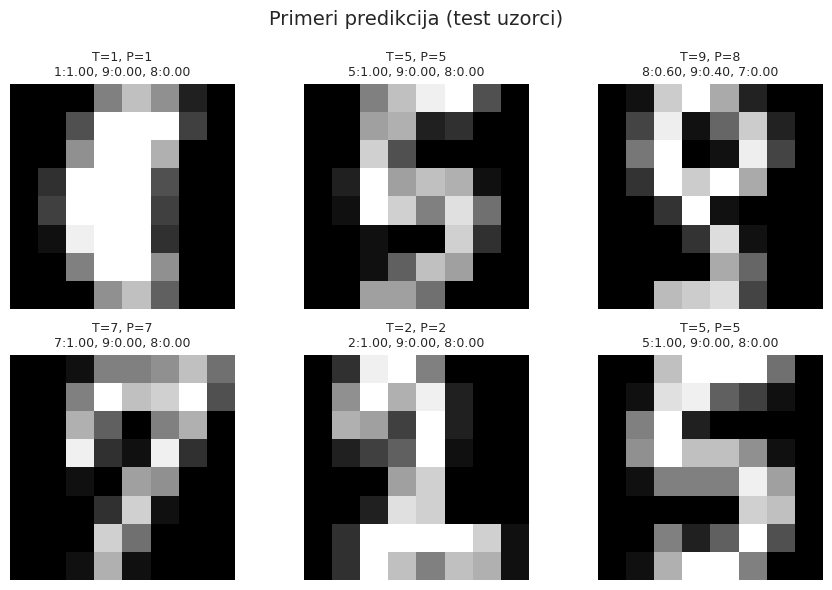

Pogrešno klasifikovanih: 16


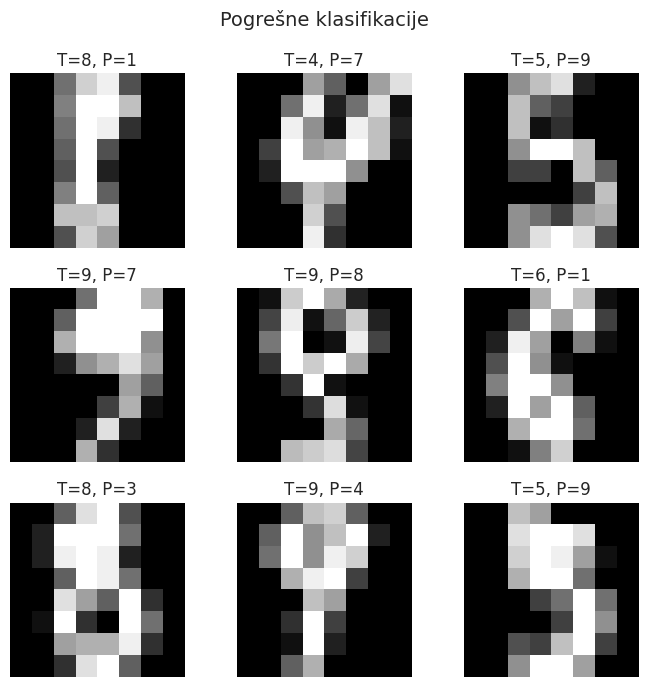

In [14]:
# Odaberemo nekoliko nasumičnih test uzoraka
rng = np.random.default_rng(42)
sample_idxs = rng.choice(len(X_test), size=6, replace=False)

probs = final_model.predict_proba(X_test[sample_idxs])
preds = final_model.predict(X_test[sample_idxs])
true = y_test[sample_idxs]

# Prikaz slika sa predikcijama i top-3 verovatnoćama
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
fig.suptitle('Primeri predikcija (test uzorci)', fontsize=14)
for ax, idx, p, pr, t in zip(axes.ravel(), sample_idxs, probs, preds, true):
    ax.imshow(X_test[idx].reshape(h, w), cmap='gray')
    top3 = np.argsort(p)[-3:][::-1]
    title = f"T={t}, P={pr}\n" + ", ".join([f"{c}:{p[c]:.2f}" for c in top3])
    ax.set_title(title, fontsize=9)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Prikaz nekoliko pogrešnih klasifikacija, ako ih ima
wrong = np.where(y_test != final_pred)[0]
print(f"Pogrešno klasifikovanih: {len(wrong)}")
if len(wrong) > 0:
    show = wrong[:9]
    fig, axes = plt.subplots(3, 3, figsize=(7, 7))
    fig.suptitle('Pogrešne klasifikacije', fontsize=14)
    for ax, i in zip(axes.ravel(), show):
        ax.imshow(X_test[i].reshape(h, w), cmap='gray')
        ax.set_title(f"T={y_test[i]}, P={final_pred[i]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## 7. Zaključak

U ovom notebook-u smo, na jednostavnom slikovnom skupu (sklearn digits, 8×8), demonstrirali:

- Učitavanje i vizuelni pregled slika i distribucije klasa
- k-NN klasifikator sa skaliranjem piksela unutar Pipeline-a
- Evaluaciju (accuracy, confusion matrix – apsolutna i normalizovana)
- Tuning hiperparametra k putem GridSearchCV (5-fold CV)
- Analizu grešaka i pregled pogrešnih predikcija

Ključne poruke:
- k-NN je jednostavan i efektan baseline za male slikovne skupove
- Skaliranje je važno jer k-NN zavisi od mera rastojanja
- Seaborn olakšava jasne vizualizacije rezultata

Napomena: Za složenije i veće slikovne skupove (npr. CIFAR-10, ImageNet), tipično se koriste konvolutivne neuronske mreže (CNN) u PyTorch/TensorFlow. Ovde smo se fokusirali na pregledan primer i transparentnu metodologiju.